In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
# import vector
from tqdm import tqdm
import time
import glob
import pickle
import os

_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
mc20 = "mc20e"
data = "2018"
btag = 'Xbb'
trigger = 'LR'
# mc20 = "mc20d"
# btag = "btag_77"
# xbbtag ="xbbtag_70"

In [3]:
directory = "EfficiencyStudies_bkg_Sep16_" + data 
path = "./"+directory
isExist = os.path.exists(path)
if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path)
    print("The new directory is created!")

The new directory is created!


# Opening Signal files

In [4]:
def apply_trigger(tree, data='2018', trigger = 'LR'):
    
    if (data == "2018"):
        lumi_b = 58.0339 #mc20e (2018)
        lumi_nonb = 58.7916 #mc20e (2018)
        mask_LRj_trigger = tree['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] == True
        mask_2b1j        = tree['HLT_j110_gsc150_boffperf_split_2j45_gsc55_bmv2c1070_split_L1J85_3J30'] == True
        mask_2b2j        = tree['HLT_2j35_bmv2c1060_split_2j35_L14J15p0ETA25'] == True
        
    elif (data == "2017"):
        lumi_b = 43.9668 #mc20d (2017)
        lumi_nonb = 44.6306 #mc20d (2017)
        mask_LRj_trigger = tree['HLT_j420_a10t_lcw_jes_40smcINF_L1J100'] == True
        mask_2b1j        = tree['HLT_j110_gsc150_boffperf_split_2j35_gsc55_bmv2c1070_split_L1J85_3J30'] == True
        mask_2b2j        = tree['HLT_2j15_gsc35_bmv2c1040_split_2j15_gsc35_boffperf_split_L14J15p0ETA25'] == True

    elif (data == "2016"):
        lumi_b = 24.8658 #mc20a (2016)
        lumi_nonb = 33.4022 #mc20a (2016)
        mask_LRj_trigger = tree['HLT_j420_a10_lcw_L1J100'] == True
        mask_2b1j        = tree['HLT_j100_2j55_bmv2c2060_split'] == True
        mask_2b2j        = tree['HLT_2j35_bmv2c2060_split_2j35_L14J15p0ETA25'] == True

    
    mask_LRjet_520                   = tree["leading_large_r_jet_pt"] > 520  
    mask_3jet_70                     = tree["S_jet1_pt"] > 70

    mask_bucket0                     = mask_LRj_trigger & mask_LRjet_520
    # mask_rejected                    = ~mask_LRj_trigger & mask_LRjet_520
    # mask_resolved                    = ~mask_LRjet_520
    mask_2b1j_noLRcut                = ~mask_LRjet_520 & mask_2b1j
    mask_2b2j_noLRcut                = ~mask_LRjet_520 & mask_2b2j

    # mask_nobucket0_2b1j              = ~mask_bucket0 & mask_2b1j
    # mask_nobucket0_2b2j              = ~mask_bucket0 & mask_2b2j

    mask_bucket0_2b1j                = mask_bucket0 | mask_2b1j_noLRcut #less inclusive than mask_nobucket0_2b1j (does not include rejected)
    mask_bucket0_2b2j                = mask_bucket0 | mask_2b2j_noLRcut #less inclusive than mask_nobucket0_2b1j (does not include rejected)

    mask_bucket1                     = ~mask_LRj_trigger & mask_3jet_70 & mask_2b1j
    mask_bucket2                     = ~mask_LRj_trigger & ~mask_3jet_70 & mask_2b2j

    mask_bucket012                   = mask_bucket0 | mask_bucket1 | mask_bucket2
    
    #assign wights according to the luminosity
    lumi_weight = np.where(mask_LRj_trigger, lumi_nonb, lumi_b)
    
    if (trigger == "LR"):
        tree = tree[mask_bucket0]
        lumi_weight = lumi_weight[mask_bucket0]
    elif (trigger == "LR_2b1j"):
        tree = tree[mask_bucket0_2b1j]
        lumi_weight = lumi_weight[mask_bucket0_2b1j]
    elif (trigger == "LR_2b2j"):
        tree = tree[mask_bucket0_2b2j]
        lumi_weight = lumi_weight[mask_bucket0_2b2j]
    elif (trigger == 'LR_resolved'):
        tree = tree[mask_bucket012]
        lumi_weight = lumi_weight[mask_bucket012]
                
    return tree, lumi_weight

In [6]:
if (data == "2016"):
    data_trees = uproot.open('/data/rainbolt/sh4b/mixed_selection/background/data16_btag77_xbbtag70.root:trees')
elif(data == "2017"):
    data_trees = uproot.open('/data/rainbolt/sh4b/mixed_selection/background/data17_btag77_xbbtag70.root:trees')
elif (data == "2018"):
    data_trees = uproot.open('/data/rainbolt/sh4b/mixed_selection/background/data18_btag77_xbbtag70.root:trees')

pass_VRL = data_trees['mixed_pass_validation_low'].arrays()
pass_CRL = data_trees['mixed_pass_control_low'].arrays()
SR       = data_trees['mixed_pass_signal'].arrays() # This should be blinded
pass_CRH = data_trees['mixed_pass_control_high'].arrays()
pass_VRH = data_trees['mixed_pass_validation_high'].arrays()


if (btag == 'Xbb'): 
    fail_VRL = data_trees['mixed_failxbb_validation_low'].arrays()
    fail_CRL = data_trees['mixed_failxbb_control_low'].arrays()
    fail_CR0 = data_trees['mixed_failxbb_signal'].arrays()
    fail_CRH = data_trees['mixed_failxbb_control_high'].arrays()
    fail_VRH = data_trees['mixed_failxbb_validation_high'].arrays()
    CR0 = fail_CR0

elif (btag == '2b'): 
    fail_VRL = data_trees['mixed_fail2b_validation_low'].arrays()
    fail_CRL = data_trees['mixed_fail2b_control_low'].arrays()
    fail_CR0 = data_trees['mixed_fail2b_signal'].arrays()
    fail_CRH = data_trees['mixed_fail2b_control_high'].arrays()
    fail_VRH = data_trees['mixed_fail2b_validation_high'].arrays()
    CR0 = fail_CR0
else:
    fail_VRL = 0
    fail_CRL = 0
    fail_CR0 = 0
    fail_CRH = 0
    fail_VRH = 0

bkg_total = ak.concatenate([fail_VRL,fail_CRL,fail_CR0,fail_CRH,fail_VRH], axis=0)                    

print('bkg_total', bkg_total)


bkg_total [{run_number: 348885, lumi_block: 217, event_number: 93596263, ...}, ..., {...}]


In [7]:
bkg_total

<Array [{run_number: 348885, ...}, ..., {...}] type='1549877 * {run_number:...'>

## Define Trigger Masks

In [8]:
if(data == "2016"):
    mask_LRj_trigger                 = bkg_total['HLT_j420_a10_lcw_L1J100'] == True
    mask_2b1j                        = bkg_total['HLT_j100_2j55_bmv2c2060_split'] == True
    mask_2b2j                        = bkg_total['HLT_2j35_bmv2c2060_split_2j35_L14J15p0ETA25'] == True
    
elif(data == "2017"):
    mask_LRj_trigger                 = bkg_total['HLT_j420_a10t_lcw_jes_40smcINF_L1J100'] == True
    mask_2b1j                        = bkg_total['HLT_j110_gsc150_boffperf_split_2j35_gsc55_bmv2c1070_split_L1J85_3J30'] == True
    mask_2b2j                        = bkg_total['HLT_2j15_gsc35_bmv2c1040_split_2j15_gsc35_boffperf_split_L14J15p0ETA25'] == True

elif(data == "2018"):
    mask_LRj_trigger                 = bkg_total['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] == True
    mask_2b1j                        = bkg_total['HLT_j110_gsc150_boffperf_split_2j45_gsc55_bmv2c1070_split_L1J85_3J30'] == True
    mask_2b2j                        = bkg_total['HLT_2j35_bmv2c1060_split_2j35_L14J15p0ETA25'] == True

    
mask_LRjet_520                   = bkg_total["leading_large_r_jet_pt"] > 520  
mask_3jet_70                     = bkg_total["S_jet1_pt"] > 70

mask_bucket0                     = mask_LRj_trigger & mask_LRjet_520
mask_rejected                    = ~mask_LRj_trigger & mask_LRjet_520
mask_resolved                    = ~mask_LRjet_520
mask_2b1j_noLRcut                = ~mask_LRjet_520 & mask_2b1j
mask_2b2j_noLRcut                = ~mask_LRjet_520 & mask_2b2j

mask_nobucket0_2b1j              = ~mask_bucket0 & mask_2b1j
mask_nobucket0_2b2j              = ~mask_bucket0 & mask_2b2j

mask_bucket0_2b1j                = mask_bucket0 | mask_2b1j_noLRcut #less inclusive than mask_nobucket0_2b1j (does not include rejected)
mask_bucket0_2b2j                = mask_bucket0 | mask_2b2j_noLRcut #less inclusive than mask_nobucket0_2b1j (does not include rejected)

mask_bucket1                     = ~mask_LRj_trigger & mask_3jet_70 & mask_2b1j
mask_bucket2                     = ~mask_LRj_trigger & ~mask_3jet_70 & mask_2b2j

mask_bucket012                   = mask_bucket0 | mask_bucket1 | mask_bucket2

In [9]:
print ("All events", len(bkg_total))
print ("Bucket 0  ", np.sum(mask_bucket0)) #events passing bucket0 (LR jet)
print ("Rejected  ", np.sum(mask_rejected)) #events rejected by bucket0 (LR jet)
print ("Resolved  ", np.sum(mask_resolved)) #events considered for a resolved bucket

print ("Check total",np.sum(mask_bucket0)+np.sum(mask_rejected)+np.sum(mask_resolved)) #should be equal to all events
print ("mask_2b1j_noLRcut       ", np.sum(mask_2b1j_noLRcut)) #2b1j no passing LR requirements
print ("mask_2b2j_noLRcut       ", np.sum(mask_2b2j_noLRcut)) #2b2j no passing LR requirements
print ("nobucket0 2b1j          ", np.sum(mask_nobucket0_2b1j)) #2b1j no passing bucket 0, including rejected
print ("nobucket0 2b2j          ", np.sum(mask_nobucket0_2b2j)) #2b2j no passing bucket 0, including rejected
print ("mask_bucket0_2b1j       ", np.sum(mask_bucket0_2b1j) ) #all events passing either bucket0 or 2b1j
print ("mask_bucket0_2b2j       ", np.sum(mask_bucket0_2b2j) ) #all events passing either bucket0 or 2b1j

All events 1549877
Bucket 0   66861
Rejected   492
Resolved   1482524
Check total 1549877
mask_2b1j_noLRcut        1190605
mask_2b2j_noLRcut        1008619
nobucket0 2b1j           1191081
nobucket0 2b2j           1008878
mask_bucket0_2b1j        1257466
mask_bucket0_2b2j        1075480


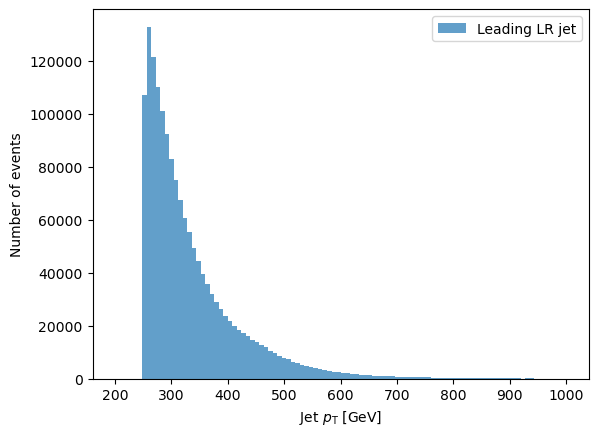

In [10]:
plt.hist(bkg_total["leading_large_r_jet_pt"], bins=100, range=(200, 1000), alpha=0.7, label="Leading LR jet")
plt.xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right') 
plt.savefig(path + '/LRjet'  + '.pdf')
plt.show()

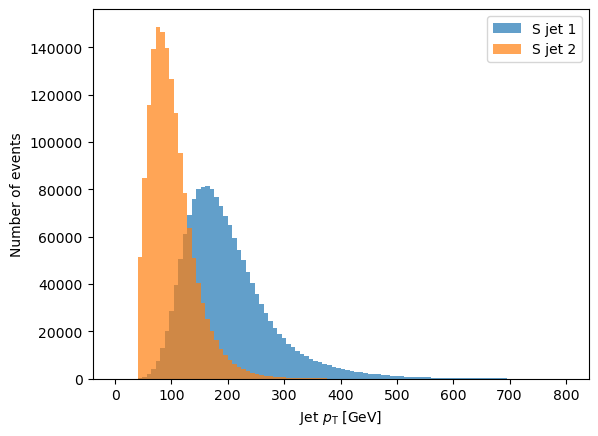

In [11]:
plt.hist(bkg_total["S_jet1_pt"], bins=100, range=(0, 800), alpha=0.7, label="S jet 1")
plt.hist(bkg_total["S_jet2_pt"], bins=100, range=(0, 800), alpha=0.7, label="S jet 2")
plt.xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right') 
plt.savefig(path + '/Sjets'  + '.pdf')
plt.show()

In [ ]:
plt.hist(bkg_total["S_jet2_pt"], bins=100, range=(0, 500), alpha=0.7, label="S jet 2")
plt.hist(bkg_total["S_jet2_pt"][mask_2b1j], bins=100, range=(0, 500), alpha=0.7, label="S jet 2, 2b1j applied")
plt.hist(bkg_total["S_jet2_pt"][mask_2b2j], bins=100, range=(0, 500), alpha=0.7, label="S jet 2, 2b2j applied")
plt.hist(bkg_total["S_jet1_pt"], bins=100, range=(0, 500), alpha=0.7, label="S jet 1")
plt.hist(bkg_total["S_jet1_pt"][mask_2b1j], bins=100, range=(0, 500), alpha=0.7, label="S jet 1, 2b1j applied")
plt.hist(bkg_total["S_jet1_pt"][mask_2b2j], bins=100, range=(0, 500), alpha=0.7, label="S jet 1, 2b2j applied")
plt.yscale('log')

plt.axvline(x = 70, color = 'b', label = '70 GeV cut')

plt.xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right') 
plt.savefig(path + '/Sjets_withTrigger'  + '.pdf')
plt.show()

In [ ]:
plt.hist(bkg_total["S_jet2_pt"], bins=100, range=(0, 500), alpha=0.7, label="S jet 2")
plt.hist(bkg_total["S_jet2_pt"][mask_nobucket0_2b1j], bins=100, range=(0, 500), alpha=0.7, label="S jet 2, no bucket0, 2b1j applied")
plt.hist(bkg_total["S_jet2_pt"][mask_nobucket0_2b2j], bins=100, range=(0, 500), alpha=0.7, label="S jet 2, no bucket0, 2b2j applied")
plt.hist(bkg_total["S_jet1_pt"], bins=100, range=(0, 500), alpha=0.7, label="S jet 1")
plt.hist(bkg_total["S_jet1_pt"][mask_nobucket0_2b1j], bins=100, range=(0, 500), alpha=0.7, label="S jet 1, no bucket0, 2b1j applied")
plt.hist(bkg_total["S_jet1_pt"][mask_nobucket0_2b2j], bins=100, range=(0, 500), alpha=0.7, label="S jet 1, no bucket0, 2b2j applied")
plt.yscale('log')

plt.axvline(x = 70, color = 'b', label = '70 GeV cut')

plt.xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right') 
plt.savefig(path + '/Sjets_withTrigger_noBucket0'  + '.pdf')
plt.show()

In [ ]:
plt.hist(bkg_total["leading_large_r_jet_pt"], bins=100, range=(200, 800), alpha=0.7, label="Leading LR jet")
# plt.hist(array["leading_large_r_jet_pt"][mask_LRj_trigger], bins=100, range=(0, 4000), alpha=0.7, label="Leading LR jet, LR trig ")
# plt.hist(bkg_total["leading_large_r_jet_pt"][mask_2b2j], bins=100, range=(200, 800), alpha=0.7, label="Leading LR jet, 2b2j trig")
# plt.hist(bkg_total["leading_large_r_jet_pt"][mask_2b1j], bins=100, range=(200, 800), alpha=0.7, label="Leading LR jet, 2b1j trig")
plt.hist(bkg_total["leading_large_r_jet_pt"][mask_nobucket0_2b2j], bins=100, range=(200, 800), alpha=0.7, label="Leading LR jet, no bucket0, 2b2j trig")
plt.hist(bkg_total["leading_large_r_jet_pt"][mask_nobucket0_2b1j], bins=100, range=(200, 800), alpha=0.7, label="Leading LR jet, no bucket0, 2b1j trig")
plt.yscale('log')
# plt.axvline(x = 500, color = 'b', label = '500 GeV cut')

plt.xlabel('$p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right') 
plt.savefig(path + '/LRjet_with_bjetTriggers_noBucket0'  + '.pdf')
plt.show()

In [ ]:
plt.hist(bkg_total["X_pt"], bins=100, range=(0, 1500), alpha=0.7, label="X pT")
# plt.hist(array["leading_large_r_jet_pt"][mask_LRj_trigger], bins=100, range=(0, 4000), alpha=0.7, label="Leading LR jet, LR trig ")
plt.hist(bkg_total["X_pt"][mask_2b1j], bins=100, range=(0, 1500), alpha=0.7, label="X pT, 2b1j trig")
plt.hist(bkg_total["X_pt"][mask_2b2j], bins=100, range=(0, 1500), alpha=0.7, label="X pT, 2b2j trig")
plt.hist(bkg_total["X_pt"][mask_nobucket0_2b1j], bins=100, range=(0, 1500), alpha=0.7, label="X pT, no bucket0, 2b1j trig")
plt.hist(bkg_total["X_pt"][mask_nobucket0_2b2j], bins=100, range=(0, 1500), alpha=0.7, label="X pT, no bucket0, 2b2j trig")
plt.yscale('log')
# plt.axvline(x = 500, color = 'b', label = '500 GeV cut')

plt.xlabel('$p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right') 
plt.savefig(path + '/pT_X'  + '.pdf')
plt.show()

In [ ]:
plt.hist(bkg_total["X_mass"], bins=100, range=(0, 5000), alpha=0.7, label="X mass")
# plt.hist(array["leading_large_r_jet_pt"][mask_LRj_trigger], bins=100, range=(0, 4000), alpha=0.7, label="Leading LR jet, LR trig ")
plt.hist(bkg_total["X_mass"][mask_2b2j], bins=100, range=(0, 5000), alpha=0.7, label="X mass, 2b2j trig")
plt.hist(bkg_total["X_mass"][mask_2b1j], bins=100, range=(0, 5000), alpha=0.7, label="X mass, 2b1j trig")
plt.hist(bkg_total["X_mass"][mask_nobucket0_2b2j], bins=100, range=(0, 5000), alpha=0.7, label="X mass, no bucket0, 2b2j trig")
plt.hist(bkg_total["X_mass"][mask_nobucket0_2b1j], bins=100, range=(0, 5000), alpha=0.7, label="X mass, no bucket0, 2b1j trig")

plt.yscale('log')
# plt.axvline(x = 500, color = 'b', label = '500 GeV cut')

plt.xlabel('X mass [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right') 
plt.savefig(path + '/Xmass'  + '.pdf')
plt.show()

In [ ]:
plt.hist(bkg_total["S_pt"], bins=100, range=(0, 1500), alpha=0.7, label="S pT")
# plt.hist(array["leading_large_r_jet_pt"][mask_LRj_trigger], bins=100, range=(0, 4000), alpha=0.7, label="Leading LR jet, LR trig ")
plt.hist(bkg_total["S_pt"][mask_2b2j], bins=100, range=(0, 1500), alpha=0.7, label="S pT, 2b2j trig")
plt.hist(bkg_total["S_pt"][mask_2b1j], bins=100, range=(0, 1500), alpha=0.7, label="S pT, 2b1j trig")
plt.hist(bkg_total["S_pt"][mask_nobucket0_2b2j], bins=100, range=(0, 1500), alpha=0.7, label="S pT, no bucket0, 2b2j trig")
plt.hist(bkg_total["S_pt"][mask_nobucket0_2b1j], bins=100, range=(0, 1500), alpha=0.7, label="S pT, no bucket0, 2b1j trig")

plt.yscale('log')
# plt.axvline(x = 500, color = 'b', label = '500 GeV cut')

plt.xlabel('$p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right') 
plt.savefig(path + '/pT_S'  + '.pdf')
plt.show()

In [ ]:
plt.hist(bkg_total["S_mass"], bins=100, range=(0, 1000), alpha=0.7, label="S mass")
# plt.hist(array["leading_large_r_jet_pt"][mask_LRj_trigger], bins=100, range=(0, 4000), alpha=0.7, label="Leading LR jet, LR trig ")
plt.hist(bkg_total["S_mass"][mask_2b2j], bins=100, range=(0, 1000), alpha=0.7, label="S mass, 2b2j trig")
plt.hist(bkg_total["S_mass"][mask_2b1j], bins=100, range=(0, 1000), alpha=0.7, label="S mass, 2b1j trig")
plt.hist(bkg_total["S_mass"][mask_nobucket0_2b2j], bins=100, range=(0, 1000), alpha=0.7, label="S mass, no bucket0, 2b2j trig")
plt.hist(bkg_total["S_mass"][mask_nobucket0_2b1j], bins=100, range=(0, 1000), alpha=0.7, label="S mass, no bucket0, 2b1j trig")
plt.yscale('log')
# plt.axvline(x = 500, color = 'b', label = '500 GeV cut')

plt.xlabel('S mass [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right') 
plt.savefig(path + '/Smass'  + '.pdf')
plt.show()

## Make efficiency plots for individual triggers

### Define the nominal mass points

In [ ]:
if (mc20 == "mc20a"):
    filenames = glob.glob('/data/rainbolt/sh4b/fixed_sh4b_selection/signal/mc20a_*.root') # list
elif(mc20 == "mc20d"):
    filenames = glob.glob('/data/rainbolt/sh4b/fixed_sh4b_selection/signal/mc20d_*.root') # list
elif (mc20 == "mc20e"):
    filenames = glob.glob('/data/rainbolt/sh4b/fixed_sh4b_selection/signal/mc20e_*.root') # list

In [ ]:
truth_X = []
truth_S = []
for filename in filenames:
    X = filename.split('mX')[1].split('_mS')[0]
    S = filename.split('mS')[1].split('_btag')[0]         
    truth_X.append(float(X))
    truth_S.append(float(S))


Round to closest 50 to get the true value, and add them to the tree

In [ ]:
all_weights = []

for filename in filenames:
    X = filename.split('mX')[1].split('_mS')[0]
    S = filename.split('mS')[1].split('_btag')[0]
    
    arr = uproot.open(filename + ':trees/mixed_pass_signal').arrays(['run_number'])
    n_sel_events = len(arr)

    cutflow = uproot.open(filename + ':cutflows')
    evt_weight = cutflow['sum_of_weights'].values()[0]

    all_weights = all_weights + ([evt_weight] * n_sel_events)
    
print(len(all_weights) == len(array))

array['n_gen_events'] = all_weights

### Plot selected events distribution to be used as denominator for the efficiency

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 7))
    
xbins = np.logspace(np.log10(1e1), np.log10(1e4), 60)
ybins = np.logspace(np.log10(1e2), np.log10(1e4), 60)

h_evts = ax.hist2d(bkg_total['S_mass'].to_numpy(),
                   bkg_total['X_mass'].to_numpy(),
                   # weights = 1/array['n_gen_events'].to_numpy(),
                   bins=[xbins, ybins],
                   cmin = 1e-9, # cmax=0.01,
                   # cmap='Blues'
                   )

cbar = fig.colorbar(h_evts[3], ax=ax)

ax.plot(truth_S, truth_X, marker='o', linestyle=None, linewidth=0, markersize=3, markerfacecolor='white', markeredgecolor='white')

# ax.legend(fontsize=16, loc='best')
ax.set_title('Selected events', loc='right', fontsize=18)
ax.set_ylabel('X Mass', fontsize=18)
ax.set_xlabel('S Mass',fontsize=18)
ax.set_xlim([1e1, 1e4])
ax.set_ylim([1e2, 1e4])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=15)
cbar.set_label('Selected Events', fontsize=18)
cbar.ax.tick_params(labelsize=18) 
# ax.grid(True)


# timestr = time.strftime("%Y%m%d-%H%M%S")
plt.savefig(path + '/selected_reco_events'  + '.pdf')
plt.show()

In [ ]:
def plot_style(ax, cbar, title, cbar_label='Selected Events', notitle=False):
    '''
    Set the axis style
    '''

    if not notitle: 
        ax.set_title(title, loc='right', fontsize=10)
    ax.set_ylabel('X Mass', fontsize=18)
    ax.set_xlabel('S Mass',fontsize=14)
    ax.set_xlim([1e1, 1e4])
    ax.set_ylim([1e2, 1e4])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(labelsize=15)

    # ax.legend(fontsize=16, loc='best')
    # ax.grid(True)

    cbar.set_label(cbar_label, fontsize=18)
    cbar.ax.tick_params(labelsize=18)

In [ ]:
def make_trigger_plot(trigger_mask, trigger_title='LRJ', plot_name='trigger_or_', simpletitle=False):
    '''
    Makes two plots:
    - left plot: events that pass the trigger
    - right plot: trigger efficiency
    
    args:
    - trigger_mask
    - trigger_title
    - plot_name
    - simpletitle: if True, only plots the trigger name in the plot title
    '''

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))
    
            
    xbins = np.logspace(np.log10(1e1), np.log10(1e4), 60)
    ybins = np.logspace(np.log10(1e2), np.log10(1e4), 60)
    
    # Selected events plot
    h_evts_tr = ax.hist2d(bkg_total[trigger_mask]['S_mass'].to_numpy(),
                          bkg_total[trigger_mask]['X_mass'].to_numpy(),
                          # weights = 1/array[trigger_mask]['n_gen_events'].to_numpy(),
                          bins=[xbins, ybins],
                          cmin = 1e-9
                             )
    cbar = fig.colorbar(h_evts_tr[3], ax=ax)
    
    ax.plot(truth_S, truth_X, marker='o', linestyle=None, linewidth=0, markersize=3, markerfacecolor='white', markeredgecolor='white')
    
    plot_style(ax, cbar, title='Selected events that pass the ' + trigger_title)
    if simpletitle:
        ax.set_title(trigger_title, loc='right', fontsize=8)
        
    # timestr = time.strftime("%Y%m%d-%H%M%S")
    # plt.savefig(path +  plot_name + timestr + '.pdf')
    # plt.show()
    
    
    # Efficiency plot
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))

    cm = plt.pcolormesh(h_evts[1], h_evts[2], (h_evts_tr[0] / h_evts[0]).T,
                        vmin=0, vmax=1,
                        cmap='viridis')
    cbar2 = fig.colorbar(cm)
    
    ax.plot(truth_S, truth_X, marker='o', linestyle=None, linewidth=0, markersize=3, markerfacecolor='white', markeredgecolor='white')
    
    num = np.sum(h_evts_tr[0][~np.isnan(h_evts_tr[0])])
    den = np.sum(h_evts[0][~np.isnan(h_evts[0])])
    eff = num / den
    ax.text(0.9e4, 1.1e2, f'Total Efficiency: {eff*100:.1f}%', fontsize=12, horizontalalignment='right')
    
    plot_style(ax, cbar2, title=f'Trigger efficiency ({trigger_title})', cbar_label='Efficiency')
    if simpletitle:
        ax.set_title(trigger_title, loc='right', fontsize=8)
    
    # timestr = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(path +"/"+  plot_name + '.pdf')
    plt.show()
    
    return ax

In [ ]:
make_trigger_plot(mask_bucket0_2b1j, trigger_title='bucket0 + 2b1j', plot_name='bucket0_2b1j', simpletitle=False)
make_trigger_plot(mask_bucket0_2b2j, trigger_title='bucket0 + 2b2j', plot_name='bucket0_2b2j', simpletitle=False)
make_trigger_plot(mask_bucket012, trigger_title='bucket 0 + 1 + 2', plot_name='bucket_012', simpletitle=False)

In [ ]:
# Remove duplicates
unique_truth_X = list(set(truth_X))
unique_truth_S = list(set(truth_S))

# Sort in ascending order
unique_truth_X.sort()
unique_truth_S.sort()

In [ ]:
base = 10
t_X = base * np.round(bkg_total['X_mass'].to_numpy()/base)
t_S = base * np.round(bkg_total['S_mass'].to_numpy()/base)

bkg_total['t_X'] = t_X
bkg_total['t_S'] = t_S


In [ ]:
t_X

In [ ]:
trigger_masks = {
        'bucket0_2b1j': mask_bucket0_2b1j,
        'bucket0_2b2j': mask_bucket0_2b2j,
        'bucket012': mask_bucket012
    }
    
eff_by_trigger = {}

for trigger, mask in trigger_masks.items():
    eff_by_trigger[trigger] = []
    for xmass in unique_truth_X:
        print(f'Looking at {trigger}, {xmass}')

        xmass_mask = bkg_total['t_X'] == xmass
        print()
        print("np.sum([xmass_mask & mask]) ",np.sum([xmass_mask & mask]) )
        print("np.sum([xmass_mask]) ",np.sum([xmass_mask]) )
        eff = np.sum([xmass_mask & mask]) / np.sum([xmass_mask])
        print("eff ",eff )
        
        eff_by_trigger[trigger].append(eff)

        # print(trigger, eff)

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 7))

for trigger in trigger_masks.keys():
    ax.plot(unique_truth_X, eff_by_trigger[trigger], label=f'Trigger {trigger}',
            linewidth=1, markersize=2, marker='o')
    # break

# ax.set_title('', loc='right', fontsize=18)
ax.set_ylabel('Trigger Efficiency', fontsize=18)
ax.set_xlabel('X Mass [GeV]',fontsize=18)
# ax.set_xlim([1e2, 1e4])
ax.set_ylim([0, 1.1])
# ax.set_xscale('log')
ax.tick_params(labelsize=15)
# for x in unique_truth_X:
#     ax.axvline(x, color='gray', alpha=0.2)
# for s in unique_truth_S:
#     ax.axvline(s, color='gray', alpha=0.2)   
ax.legend(fontsize=16, loc='right')
#'best'
# ax.grid(True)

timestr = time.strftime("%Y%m%d-%H%M%S")
plt.savefig(path + '/trigger_efficiency_vs_Xmass_' + timestr + '.pdf')
plt.show()

In [ ]:
eff_by_trigger_S = {}

for trigger, mask in trigger_masks.items():
    eff_by_trigger_S[trigger] = []
    for smass in unique_truth_S:
        print(f'Looking at {trigger}, {smass}')

        smass_mask = bkg_total['t_X'] == smass
        print()
        print("np.sum([smass_mask & mask]) ",np.sum([smass_mask & mask]) )
        print("np.sum([smass_mask]) ",np.sum([smass_mask]) )
        eff = np.sum([smass_mask & mask]) / np.sum([smass_mask])
        print("eff ",eff )       
        eff_by_trigger_S[trigger].append(eff)

        # print(trigger, eff)
        # break

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 7))

for trigger in trigger_masks.keys():
    ax.plot(unique_truth_S, eff_by_trigger_S[trigger], label=f'Trigger {trigger}',
            linewidth=1, markersize=2, marker='o')
    # break

# ax.set_title('', loc='right', fontsize=18)
ax.set_ylabel('Trigger Efficiency', fontsize=18)
ax.set_xlabel('S Mass [GeV]',fontsize=18)
# ax.set_xlim([1e2, 1e4])
ax.set_ylim([0, 1.1])
# ax.set_xscale('log')
ax.tick_params(labelsize=15)
for s in unique_truth_S:
    ax.axvline(s, color='gray', alpha=0.2)

ax.legend(fontsize=16, loc='right')
#'best'
# ax.grid(True)

timestr = time.strftime("%Y%m%d-%H%M%S")
plt.savefig(path + '/trigger_efficiency_vs_Smass_' + timestr + '.pdf')
plt.show()